In [74]:
import cudf
import cupy
import glob
import xarray
import scipy.io as sio
import datashader as ds
import numpy as np
from collections import OrderedDict
import datashader.transfer_functions as tf
import pandas as pd
import matplotlib.pyplot as plt
from cupyx.scipy.special import kl_div
import seaborn as sns
from matplotlib.colors import LogNorm

In [89]:
data = sio.loadmat('pavia.mat')
gt = sio.loadmat('pavia_gt.mat')
mask = sio.loadmat('PaviaGrTruthMask.mat')
wvs = sio.loadmat('PaviaWavelengths.mat')
hsi = data['paviaU']
gt = gt['paviaU_gt']
mask = mask['PaviaGrTruthMask']
wvs = wvs['PaviaWavelengths']
wvs = cupy.squeeze(np.round(wvs,3),axis=0)*1000

In [90]:
hsi_vec = cupy.reshape(hsi,(hsi.shape[0]*hsi.shape[1],hsi.shape[2]))
mask_vec = cupy.reshape(mask,(mask.shape[0]*mask.shape[1],)).astype(bool)
hsi_vec = hsi_vec/cupy.max(hsi_vec)
hsi_vec[hsi_vec==0]=0.0001
hsi_vec = cupy.array(hsi_vec)
hsi_vec.shape

(207400, 103)

In [91]:
time = cupy.linspace(0,1,len(hsi_vec))
cdf = cudf.DataFrame(hsi_vec,columns=wvs)
cdf.head()

,430.0,434.0,438.0,443.0,447.0,451.0,455.0,460.0,464.0,468.0,...,822.0,826.0,830.0,835.0,839.0,843.0,847.0,852.0,856.0,860.0
0,0.080875,0.062375,0.058000,0.046375,0.036375,0.039875,0.045625,0.04025,0.037000,0.038125,...,0.427500,0.427000,0.416875,0.407000,0.403250,0.400625,0.401250,0.402625,0.404750,0.406250
1,0.075500,0.068250,0.065875,0.056875,0.047250,0.047125,0.042000,0.03925,0.040500,0.041125,...,0.325625,0.322875,0.317250,0.313625,0.313875,0.312625,0.308500,0.305250,0.308000,0.316000
2,0.077625,0.093250,0.069500,0.045000,0.035625,0.037500,0.034250,0.03450,0.041500,0.039875,...,0.285250,0.286000,0.280250,0.274125,0.275250,0.278125,0.283250,0.288500,0.293125,0.295125
3,0.079625,0.074000,0.060250,0.069500,0.063500,0.035500,0.022250,0.02475,0.024125,0.028000,...,0.335500,0.334375,0.326125,0.317625,0.318875,0.321375,0.321125,0.321625,0.327500,0.330500
4,0.078125,0.070000,0.060000,0.045000,0.047125,0.042625,0.033000,0.02600,0.028875,0.033250,...,0.302875,0.299000,0.293000,0.286125,0.291000,0.301875,0.303000,0.298250,0.303875,0.307000


In [93]:
sim_mat = cupy.zeros((hsi_vec.shape[1],hsi_vec.shape[1]))
for i in range(0,sim_mat.shape[0]):
    v1 = hsi_vec[:,i]
    for j in range(0,sim_mat.shape[1]):
        v2 = hsi_vec[:,j]
        sim_mat[i,j] = .5*cupy.sum(kl_div(v1,v2))+.5*cupy.sum(kl_div(v2,v1))+0.001

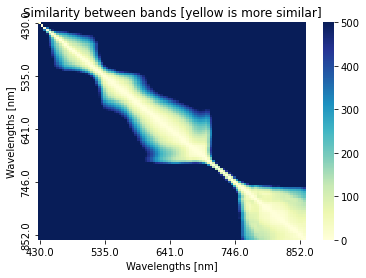

In [94]:
df = pd.DataFrame(sim_mat.get(),columns=wvs,index=wvs)
p = sns.heatmap(df, cmap="YlGnBu", xticklabels=25, yticklabels=25, vmin=0, vmax=500)
p.set_xlabel("Wavelengths [nm]")
p.set_ylabel("Wavelengths [nm]")
p.set(title="Similarity between bands [yellow is more similar]");

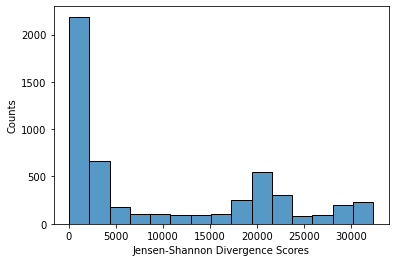

In [104]:
p = sns.histplot(data=np.triu(sim_mat.get()),x=np.unique(sim_mat.get()))
p.set_xlabel("Jensen-Shannon Divergence Scores")
p.set_ylabel("Counts");

In [95]:
sim_mask = sim_mat>0.001&sim_mat<10000

array(0.001)